In [1]:
import keras

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import os
import talos as ta
from talos.model.early_stopper import early_stopper


%load_ext tensorboard
import tensorflow_addons as tfa
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.metrics import Recall, Precision
import seaborn as sns



import tensorflow as tf

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [3]:
from tensorflow.keras.utils import model_to_dot

In [4]:

def numerai_model(shape,params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=shape,
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(params['last_neuron'], activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=2,beta=1.0)])
    
    a="""
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.57142857,
                                      1 : 4},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )
    """
    return model

In [5]:
##N -114
p_n = {
    'first_neuron':220,  #Done
     'hidden_neuron':50, #Done

     'hidden_layers':3, #Done 

     
    'epochs': 100000, # never touch it


    'last_activation': 'softmax', #never touch it


    'batch_size': 64,#Done

   'lr':0.0001,

    
    'kernel_regularizer_l1':0.00001,#Done
    'kernel_regularizer_l2':0.1,#Done
    'bias_regularizer':0.01,#Done
    'activity_regularizer':0.01,#Done

    'dropout': 0.8,
    
  
    'kernel_initializer': 'orthogonal',#Done

    'activation_layer':'selu',#Done
    'last_neuron':2,
    'batc_normalization':True#Done

}

In [6]:
##M - 110
#Nowe
p_m = {
    'first_neuron':55,  #Done
     'hidden_neuron':50, #Done

     'hidden_layers':3,  

     
    'epochs': 100000, # never touch it


    'last_activation': 'softmax', #never touch it


    'batch_size': 64,#done

    'lr':0.0001,

    
    'kernel_regularizer_l1':0.000001,
    'kernel_regularizer_l2':0.0001,
    'bias_regularizer':0.5,
    'activity_regularizer':0.0001,
    'dropout': 0,
    
  
    'kernel_initializer': 'uniform', #done
    'activation_layer':'tanh',
    'batc_normalization':True, #done
    'last_neuron':2
}


In [7]:
##T - 105
p_t = {
    'first_neuron':55,  #Done
     'hidden_neuron':50, #Done

     'hidden_layers':3,   #Done

     
    'epochs': 100000, # never touch it


    'last_activation': 'sigmoid', #never touch it


    'batch_size':64, #Done

    'lr':0.001,
    
    'kernel_regularizer_l1':0.000001,#Done
    'kernel_regularizer_l2':0.00001,#Done
    'bias_regularizer':0.0001,#Done
    'activity_regularizer':0.0001,#Done

    'dropout': 0.3,
    
  
    'kernel_initializer': 'uniform',#Done

    'activation_layer':'tanh',#Done
 
    'batc_normalization':True,#Done
    'last_neuron':3
}

In [8]:
def plot_model(model,
               to_file='model.png',
               show_shapes=False,
               show_layer_names=True,
               rankdir='TB'):
    """Converts a Keras model to dot format and save to a file.

    # Arguments
        model: A Keras model instance
        to_file: File name of the plot image.
        show_shapes: whether to display shape information.
        show_layer_names: whether to display layer names.
        rankdir: `rankdir` argument passed to PyDot,
            a string specifying the format of the plot:
            'TB' creates a vertical plot;
            'LR' creates a horizontal plot.
    """
    dot = model_to_dot(model, show_shapes, show_layer_names, rankdir)
    _, extension = os.path.splitext(to_file)
    if not extension:
        extension = 'png'
    else:
        extension = extension[1:]
    dot.write(to_file, format=extension)

In [9]:
#m_n=numerai_model(114,p_n)

In [10]:
m_m=numerai_model(110,p_m)

{'first_neuron': 55, 'hidden_neuron': 50, 'hidden_layers': 3, 'epochs': 100000, 'last_activation': 'softmax', 'batch_size': 64, 'lr': 0.0001, 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 0.0001, 'bias_regularizer': 0.5, 'activity_regularizer': 0.0001, 'dropout': 0, 'kernel_initializer': 'uniform', 'activation_layer': 'tanh', 'batc_normalization': True, 'last_neuron': 2}
adding layer 1
adding layer 2
adding layer 3


In [11]:
#m_t=numerai_model(105,p_t)

In [12]:
st="""
tf.keras.utils.plot_model(
    m_t,
    to_file="model_M.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)
"""

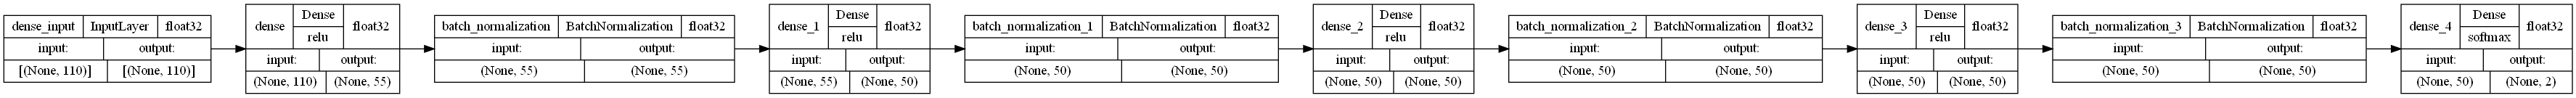

In [13]:

tf.keras.utils.plot_model(
    m_m,
    to_file="model_M.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


In [14]:
sta="""tf.keras.utils.plot_model(
    m_n,
    to_file="model_N.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)
"""